In [1]:
import pandas as pd
import numpy as np
import torch
from kan import *
import copy


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Download data: https://colab.research.google.com/github/deepmind/mathematics_conjectures/blob/main/knot_theory.ipynb#scrollTo=l10N2ZbHu6Ob
df = pd.read_csv("./knot_data.csv")
df.keys()

X = df[df.keys()[1:-1]].to_numpy()
Y = df[['signature']].to_numpy()

# normalize X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean[np.newaxis,:])/X_std[np.newaxis,:]
input_normalier = [X_mean, X_std]

# normalize Y
max_signature = np.max(Y)
min_signature = np.min(Y)
Y = ((Y-min_signature)/2).astype(int)
n_class = int((max_signature-min_signature)/2+1)
output_normalier = [min_signature, 2]

dataset = {}
num = X.shape[0]
n_feature = X.shape[1]
train_ratio = 0.8
train_id_ = np.random.choice(num, int(num*train_ratio), replace=False)
test_id_ = np.array(list(set(range(num))-set(train_id_)))

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(X[train_id_]).type(dtype)
dataset['train_label'] = torch.from_numpy(Y[train_id_][:,0]).type(torch.long)
dataset['test_input'] = torch.from_numpy(X[test_id_]).type(dtype)
dataset['test_label'] = torch.from_numpy(Y[test_id_][:,0]).type(torch.long)


In [2]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

model = KAN(width=[n_feature,1,n_class], grid=5, k=3, seed=seed)
model.fit(dataset, lamb=0.005, batch=1024, loss_fn = nn.CrossEntropyLoss(), metrics=[train_acc, test_acc], display_metrics=['train_loss', 'reg', 'train_acc', 'test_acc']);

checkpoint directory created: ./model
saving model version 0.0


 train_loss: 7.68e-01 | reg: 3.85e+01 | train_acc: 7.62e-01 | test_acc: 7.66e-01 |: 100%|█| 100/100 

saving model version 0.1


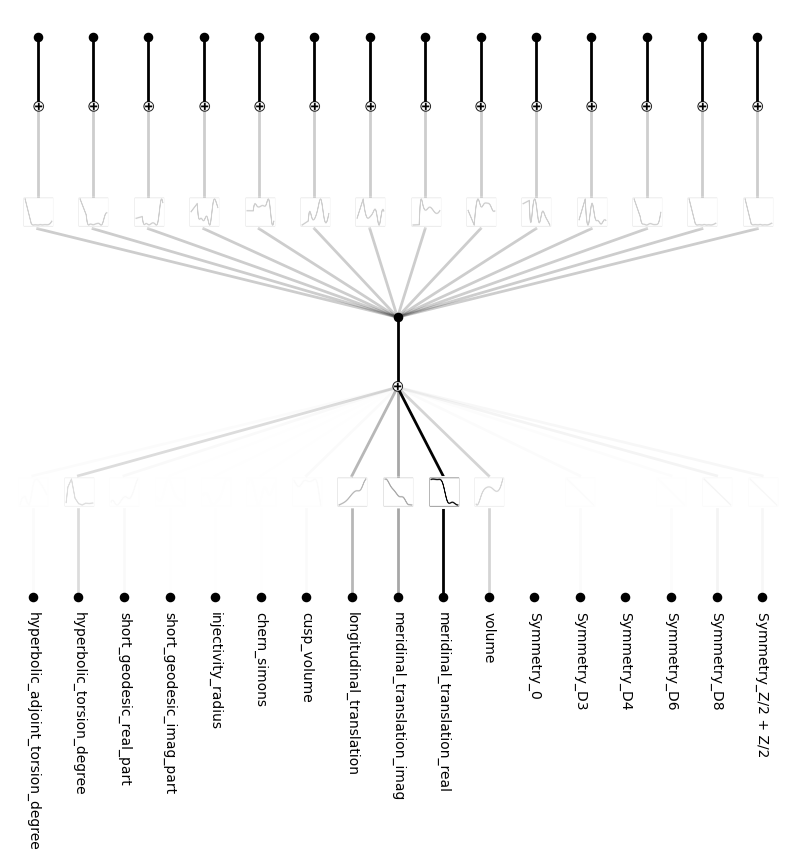

In [5]:
model.plot(scale=1.0, beta=0.2)

n = 17
for i in range(n):
    plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,df.keys()[1:-1][i], rotation=270, rotation_mode="anchor")

Text(0, 0.5, 'feature importance')

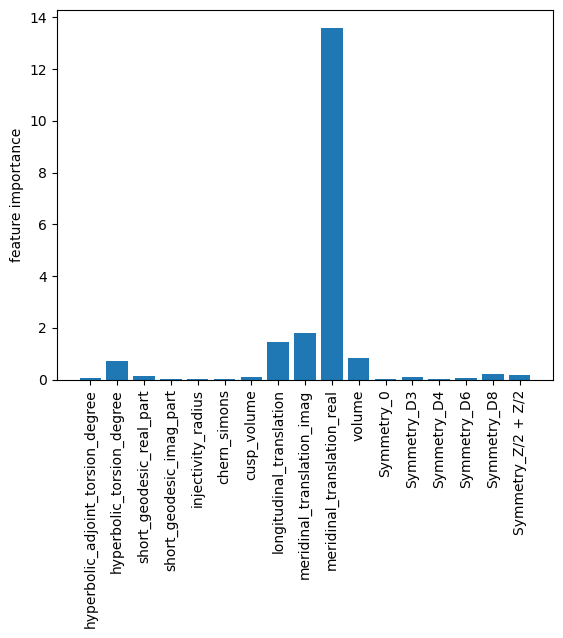

In [6]:
scores = model.feature_score
features = list(df.keys()[1:-1])

y_pos = range(len(features))
plt.bar(y_pos, scores)
plt.xticks(y_pos, features, rotation=90);
plt.ylabel('feature importance')